## Get data

In [1]:
from pyjstat import pyjstat
import pandas as pd
import json
import requests
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
POST_URL = "https://data.ssb.no/api/v0/no/table/06913/"

payload = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "agg:KommSummerHist",
        "values": [
          "K_3449",
          "K_3450",
          "K_3451",
          "K_3452",
          "K_3453",
          "K_3454"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

In [3]:
resultat = requests.post(POST_URL, json = payload)
print(resultat)

<Response [200]>


In [4]:
dataset = pyjstat.Dataset.read(resultat.text)
df = dataset.write('dataframe')

In [5]:
df.head()
#df.tail()
#df.info()

,region,statistikkvariabel,år,value
0,Sør-Aurdal,Befolkning 1. januar,1951,4103.0
1,Sør-Aurdal,Befolkning 1. januar,1952,4134.0
2,Sør-Aurdal,Befolkning 1. januar,1953,4171.0
3,Sør-Aurdal,Befolkning 1. januar,1954,4145.0
4,Sør-Aurdal,Befolkning 1. januar,1955,4167.0


In [6]:
print(df.statistikkvariabel.unique())

['Befolkning 1. januar' 'Levendefødte' 'Døde' 'Fødselsoverskudd'
 'Innflyttinger' 'Utflyttinger' 'Nettoinnflytting' 'Folketilvekst']


In [7]:
new = {"Befolkning 1. januar": "befolkning",
       "Levendefødte": "born",
       "Døde": "death",
       "år": "year"}

In [8]:
df = df.replace(new)

In [10]:
df = df[df.statistikkvariabel.isin(["befolkning", "born", "death"])].reset_index(drop=True)

In [12]:
df = df.groupby(["år", "statistikkvariabel"]).sum().reset_index()

In [14]:
df = df.pivot(index='år', columns='statistikkvariabel', values='value').reset_index()

In [15]:
df

statistikkvariabel,år,befolkning,born,death
0,1951,19269.0,356.0,164.0
1,1952,19245.0,319.0,161.0
2,1953,19299.0,287.0,167.0
3,1954,19278.0,295.0,214.0
4,1955,19263.0,290.0,162.0
...,...,...,...,...
67,2018,17770.0,126.0,187.0
68,2019,17657.0,145.0,216.0
69,2020,17578.0,125.0,191.0
70,2021,17450.0,111.0,182.0


In [87]:
for i in df.columns.tolist():
    if df[f"{i}"].dtypes == np.float64:
        df[f"{i}"] = df[f"{i}"].astype(np.int64)

In [91]:
df["bsurplus"] = df.born - df.death

In [101]:
df["endyear"] = df.befolkning.shift(-1, fill_value=0).astype(np.int64)

In [105]:
df = df[df["år"] != '2022']

In [117]:
df["moved"] = df.endyear - df.befolkning - df.bsurplus

<ipython-input-117-b1c6fe9c51a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["moved"] = df.endyear - df.befolkning - df.bsurplus


In [121]:
df

statistikkvariabel,år,befolkning,born,death,bsurplus,endyear,moved
0,1951,19269,356,164,192,19245,-216
1,1952,19245,319,161,158,19299,-104
2,1953,19299,287,167,120,19278,-141
3,1954,19278,295,214,81,19263,-96
4,1955,19263,290,162,128,19254,-137
...,...,...,...,...,...,...,...
66,2017,17825,141,200,-59,17770,4
67,2018,17770,126,187,-61,17657,-52
68,2019,17657,145,216,-71,17578,-8
69,2020,17578,125,191,-66,17450,-62


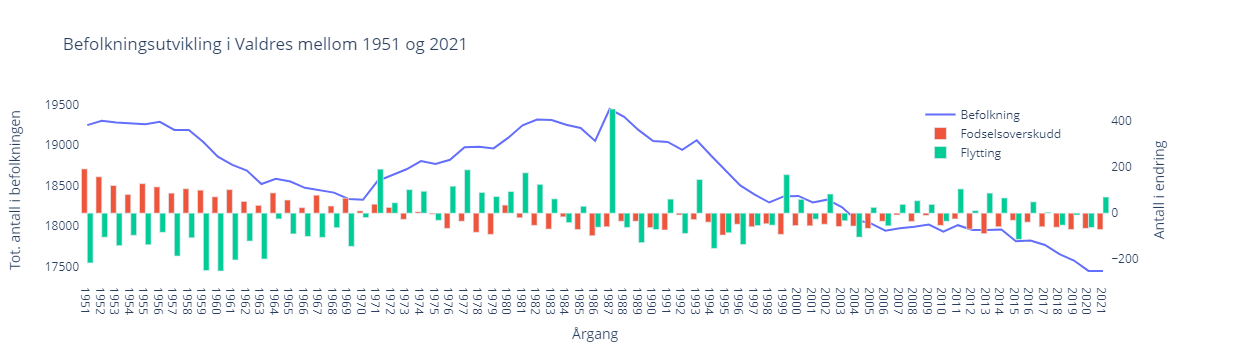

In [158]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df["år"], y=df.endyear, name="Befolkning"),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=df["år"], y=df.bsurplus, name="Fodselsoverskudd"),
    secondary_y=True,
)
fig.add_trace(
    go.Bar(x=df["år"], y=df.moved, name="Flytting"),
    secondary_y=True,
)
fig.update_layout(
    title_text="Befolkningsutvikling i Valdres mellom 1951 og 2021"
)

# Set x-axis title
fig.update_xaxes(title_text="Årgang")

# Set y-axes titles
fig.update_yaxes(title_text="Tot. antall i befolkningen", secondary_y=False, tickformat = "000")
fig.update_yaxes(title_text="Antall i endring", secondary_y=True)
fig.update_layout(hovermode='x unified', plot_bgcolor="white",
                 legend=dict(
                     yanchor="top",
                     y=1,
                     xanchor="right",
                     x=0.90
                 ))
fig.show()

In [159]:
fig.write_html("ValdresBefolkningfra2051til2021.html")

In [166]:
from PIL import Image
filename = r'jhikon.png'
img = Image.open(filename)
img.save('jhikon.ico')

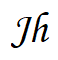

In [165]:
img